<a href="https://colab.research.google.com/github/nueveonce/Etapa3DS/blob/main/Etapa3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto NLP: Análisis de Ofertas de Trabajo en LinkedIn

# 1. Descripción del Problema de Negocio

Las empresas publican miles de ofertas de trabajo diariamente en plataformas como LinkedIn. Analizar manualmente estas descripciones para extraer información relevante (habilidades requeridas, tipo de contrato, sentimiento general de la oferta, etc.) es una tarea ardua y consume mucho tiempo. Existe la necesidad de automatizar este análisis para identificar tendencias del mercado laboral, optimizar la redacción de ofertas y facilitar a los candidatos la búsqueda de puestos adecuados.


# 2. Objetivo General
Aplicar técnicas de Procesamiento de Lenguaje Natural (NLP) para analizar y extraer información valiosa de las descripciones de puestos de trabajo publicados en LinkedIn. Específicamente, se buscará:
 * Preprocesar el texto de las descripciones.
 * Identificar las palabras y términos más frecuentes y significativos.
 * Analizar el sentimiento general expresado en las descripciones.
 * Desarrollar un modelo de clasificación para predecir alguna característica de la oferta (ej. "seniority" inferida).

## 3. Origen de los Datos
El dataset proviene de LinkedIn y contiene información sobre ofertas de trabajo. La columna principal para el análisis NLP será 'description'.

# 4.Definición de las Variables:

id: Identificador único del trabajo (Numérico).
* title: Nombre del puesto de trabajo (Texto). Potencialmente útil para NLP, podría combinarse con 'description' o usarse para filtrar.
* company: Nombre de la empresa (Texto).
* location: Nombre del país del puesto de trabajo (Texto).
* link: URL de LinkedIn (Texto).
source: Siempre es LinkedIn (Texto).
* date_posted: Fecha de publicación del puesto de trabajo (Fecha/Texto). Podría usarse para análisis de tendencias temporales, pero no directamente para NLP del contenido.
* work_type: - No disponible/Vacío.
* employment_type: - No disponible/Vacío.
* description: Descripción del trabajo (Texto). Esta será la columna principal para el análisis NLP.

# 5.Librerias utilizadas

In [4]:
# Importación otros
import time
# Manipulación de datos
import pandas as pd
import numpy as np

# NLP
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Para lematización
from nltk.stem import PorterStemmer # Para stemming (opcional)
from nltk.util import ngrams
from collections import Counter

# Para TF-IDF y BoW, y Modelos de ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Análisis de Sentimiento
from textblob import TextBlob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Si se usa VADER para inglés


# pd.set_option('display.max_colwidth', 200) # Para ver más texto en las celdas de pandas

# Descargar recursos de NLTK (ejecutar solo una vez si es necesario)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True)
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4', quiet=True) # Open Multilingual Wordnet


# Importación de dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

try:
    print("Intentando cargar el DataFrame...")
    start_time = time.time()

    ruta = '/content/drive/MyDrive/Colab'+' '+'Notebooks/Datasets/clean_jobs.csv'
    df = pd.read_csv(ruta, sep=",")

    print(f"Carga exitosa! Tiempo: {time.time()-start_time:.2f} segundos")

except FileNotFoundError:
    print("ERROR: Archivo no encontrado. Verifica la ruta.")
    print(ruta)
except Exception as e:
    print(f"ERROR inesperado: {str(e)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Intentando cargar el DataFrame...
Carga exitosa! Tiempo: 0.06 segundos


# 6 Desarrollo

## 6.1. Lectura del documento

In [6]:
df.head(5)

,id,title,company,location,link,source,date_posted,work_type,employment_type,description
0,1,Data Analyst,Meta,"New York, NY",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
1,2,Data Analyst,Meta,"San Francisco, CA",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
2,3,Data Analyst,Meta,"Los Angeles, CA",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
3,4,Data Analyst,Meta,"Washington, DC",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-14,NaN,NaN,The Social Measurement team is a growing team ...
4,5,Data Analyst II,Pinterest,"Chicago, IL",https://www.linkedin.com/jobs/view/data-analys...,LinkedIn,2025-04-16,NaN,NaN,About Pinterest\n\nMillions of people around t...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               327 non-null    int64  
 1   title            327 non-null    object 
 2   company          327 non-null    object 
 3   location         327 non-null    object 
 4   link             327 non-null    object 
 5   source           327 non-null    object 
 6   date_posted      327 non-null    object 
 7   work_type        0 non-null      float64
 8   employment_type  0 non-null      float64
 9   description      327 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 25.7+ KB


### 6.1.1 Busqueda de valores nulos

In [8]:
df.isnull().sum()

,0
id,0
title,0
company,0
location,0
link,0
source,0
date_posted,0
work_type,327
employment_type,327
description,0


### 6.1.3 Eliminacion de velores nulos

In [9]:
# Se decide eliminar las columnas work_type y employment_type ya que no contienen valores en todo el dataset
df = df.drop(['work_type', 'employment_type'], axis=1)

## 6.2. Quitar simbolos y signos de puntuación

In [10]:
def limpiar_texto(texto):

    # Quitar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)

    # Quitar emails
    texto = re.sub(r'\S*@\S*\s?', '', texto)

    # Quitar saltos de línea y caracteres especiales (manteniendo espacios)
    texto = re.sub(r'\s+', ' ', texto) # Reemplazar múltiples espacios con uno solo
    texto = re.sub(r'(\r\n|\r|\n)', ' ', texto) # Reemplazar saltos de línea con espacio

    # Quitar caracteres que no sean alfanuméricos (excepto espacios)
    texto = re.sub(r'[^\w\s]', '', texto) # Esto quitaría también acentos
    # Una mejor aproximación es quitar solo la puntuación explícitamente
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    # Quitar números si no son relevantes (opcional)
    texto = re.sub(r'\d+', '', texto)
    return texto.strip() # Eliminar espacios al inicio y al final

df['descripcion_limpia'] = df['description'].astype(str).apply(limpiar_texto)
print("\nEjemplo de descripción limpia:")
print(df['descripcion_limpia'].iloc[6])


Ejemplo de descripción limpia:
Netflix is one of the worlds leading entertainment services with  million paid memberships in over  countries enjoying TV series films and games across a wide variety of genres and languages Members can play pause and resume watching as much as they want anytime anywhere and can change their plans at any time Netflix is seeking a skilled and motivated Production Finance Tax and Vendor Data Analyst to join our team This role is pivotal in supporting our Production Finance teams with tasks related to Netflixs  Tax and Sustainability reporting The ideal candidate will have a strong skills in both data analysis and communication Responsibilities  Tax Analysis Data Pipeline Maintenance Monitor data pipelines to ensure continuous data flow for  tax forms ensuring data is flowing correctly and is available for analysis Data Modeling And Scripting Create and maintain SQL queries for data extraction analysis and reporting Focus on data consumption reconciliation 

In [11]:
# mostamos solo las columnas descripcion_limpia y description
df[['descripcion_limpia', 'description']].head(10)

,descripcion_limpia,description
0,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
1,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
2,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
3,The Social Measurement team is a growing team ...,The Social Measurement team is a growing team ...
4,About Pinterest Millions of people around the ...,About Pinterest\n\nMillions of people around t...
5,About Fanduel FanDuel Group is the premier mob...,About Fanduel\n\nFanDuel Group is the premier ...
6,Netflix is one of the worlds leading entertain...,Netflix is one of the world's leading entertai...
7,About Fanduel FanDuel Group is the premier mob...,About Fanduel\n\nFanDuel Group is the premier ...
8,Data Analyst Ecommerce Marketing Analytics Lo...,Data Analyst (Ecommerce & Marketing Analytics)...
9,About Pinterest Millions of people around the ...,About Pinterest\n\nMillions of people around t...


# Tokenizar
El propósito de la tokenización es dividir el texto en unidades significativas para construir un vocabulario que permita representar todas las palabras de manera única en una lista. Esta división es útil para análisis posteriores, como el etiquetado de partes del discurso (POS Tagging), donde se utiliza un paso de tokenizar el texto.

In [12]:
def descargar_recursos_nltk():
    recursos = ['punkt', 'punkt_tab', 'punkt-table', 'stopwords']  # Agrega otros que necesites
    for recurso in recursos:
        try:
            nltk.download(recurso)
        except:
            print(f"El recurso 😫 {recurso} no pudo ser descargado o ya existe")

descargar_recursos_nltk()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Error loading punkt-table: Package 'punkt-table' not found
[nltk_data]     in index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def tokenizar_texto(texto):
    tokens = nltk.word_tokenize(texto, language='english' if any(c in 'áéíóúñ' for c in texto.lower()) else 'english')
    return tokens

df['tokens'] = df['descripcion_limpia'].apply(tokenizar_texto)
print("\nEjemplo de tokens:")
print(df['tokens'].iloc[0][:20]) # Mostrar los primeros 20 tokens


Ejemplo de tokens:
['The', 'Social', 'Measurement', 'team', 'is', 'a', 'growing', 'team', 'with', 'highvisibility', 'within', 'the', 'Communications', 'organization', 'that', 'is', 'being', 'tasked', 'with', 'measuring']


## 6.3. Convertir a minusculas

In [14]:
df['tokens_minusculas'] = df['tokens'].apply(lambda lista_tokens: [token.lower() for token in lista_tokens])

print("\nEjemplo de tokens en minúsculas (verificando):")
print(df['tokens_minusculas'].iloc[0][:20])



Ejemplo de tokens en minúsculas (verificando):
['the', 'social', 'measurement', 'team', 'is', 'a', 'growing', 'team', 'with', 'highvisibility', 'within', 'the', 'communications', 'organization', 'that', 'is', 'being', 'tasked', 'with', 'measuring']


## 6.4. Remoción de Stopwords
Eliminar palabras muy comunes que no aportan significado específico al contenido de una oferta de trabajo (ej. "the", "is", "a", "and").

In [15]:
# Obtener stopwords en inglés
stop_words = set(stopwords.words('english'))
print(stop_words)

{'where', "it's", 's', 'no', 'wasn', "mightn't", 'both', 'hers', "they'd", "don't", 'other', 'them', 'such', 'more', 'their', 'through', 'to', "you've", 'my', 'did', 'shan', 'with', 'is', "haven't", 'there', "aren't", "we're", 'himself', 'under', 'not', 'haven', "it'll", 'needn', "weren't", 'while', 'ain', 'o', "i've", "she's", 'over', 'from', 'most', 'm', 'after', "she'll", 'having', "wasn't", 'him', 'herself', 'had', "she'd", 'wouldn', 'being', 'against', 'each', 'too', 'above', 'by', "hadn't", 'than', 'nor', 'he', 'itself', 'now', 'any', 'should', 't', 'so', 'do', 'yourselves', 'doing', 'at', 'weren', 'about', 'just', "should've", 'why', 'in', 'can', 'does', 'couldn', 'has', 'her', "we've", "couldn't", 'doesn', "they'll", 'we', 'some', 'themselves', 'have', 'for', "doesn't", "that'll", "we'll", 'very', "he'd", 'all', "isn't", 'you', 'out', 'were', "you'll", "it'd", 'below', 'me', "i'll", 'she', 'y', 'aren', 'it', 'of', 'they', 'until', 'who', 'am', 'a', 'because', 'here', "didn't", 

In [16]:
def remover_stopwords(lista_tokens):
    tokens_filtrados = [token for token in lista_tokens if token.isalpha() and token not in stop_words and len(token) > 1]
    # token.isalpha() asegura que solo sean palabras (sin números o puntuación restante)
    # len(token) > 1 para quitar letras sueltas.
    return tokens_filtrados

df['tokens_sin_stopwords'] = df['tokens_minusculas'].apply(remover_stopwords)

print("\nEjemplo de tokens sin stopwords (primeros 20 de la primera descripción):")
print(df['tokens_sin_stopwords'].iloc[0][:20])


Ejemplo de tokens sin stopwords (primeros 20 de la primera descripción):
['social', 'measurement', 'team', 'growing', 'team', 'highvisibility', 'within', 'communications', 'organization', 'tasked', 'measuring', 'efficacy', 'impact', 'socialfirst', 'communications', 'marketing', 'efforts', 'youll', 'play', 'unique']


## 6.5. Lematización
Aplicamos lematización para llevar las palabras a su forma fundamental. Por ejemplo, 'habilidades' y 'habilidad' se tratan como el mismo concepto. Esto nos ayuda a consolidar el significado y a no tratar variaciones de la misma palabra como términos diferentes

In [17]:
lemmatizer = WordNetLemmatizer()

def lematizar_tokens(lista_tokens):
    # Se asume que el idioma principal es inglés para WordNetLemmatizer.
    # El POS tag puede mejorar la lematización, pero para simplificar, no se usa aquí.
    tokens_lematizados = [lemmatizer.lemmatize(token) for token in lista_tokens]
    return tokens_lematizados

df['tokens_lematizados'] = df['tokens_sin_stopwords'].apply(lematizar_tokens)

print("\nEjemplo de tokens lematizados (primeros 20 de la primera descripción):")
print(df['tokens_lematizados'].iloc[0][:20])

# Crear una columna con el texto preprocesado final (lista de tokens unidos)
df['descripcion_procesada_final'] = df['tokens_lematizados'].apply(lambda tokens: " ".join(tokens))



Ejemplo de tokens lematizados (primeros 20 de la primera descripción):
['social', 'measurement', 'team', 'growing', 'team', 'highvisibility', 'within', 'communication', 'organization', 'tasked', 'measuring', 'efficacy', 'impact', 'socialfirst', 'communication', 'marketing', 'effort', 'youll', 'play', 'unique']


**Resultado Final del Preprocesamiento:** Una columna (descripcion_procesada_final) con texto limpio, tokenizado, sin stopwords y lematizado, listo para análisis más profundos.

## 6.6. Nubes de palabras
* La nube de palabras es una representación visual de las palabras más
frecuentes. Cuanto más grande la palabra, más frecuente es. De un vistazo, identificamos los términos dominantes como "team", "machine learning", "year experience", "data Scientist" muy grandes, sabemos que son habilidades o conceptos centrales.

* Generamos nubes de palabras para visualizar rápidamente los términos más recurrentes. Esto nos dio una primera idea de las tecnologías, habilidades y conceptos más mencionados en las descripciones de trabajo.


Generando nube de palabras general...


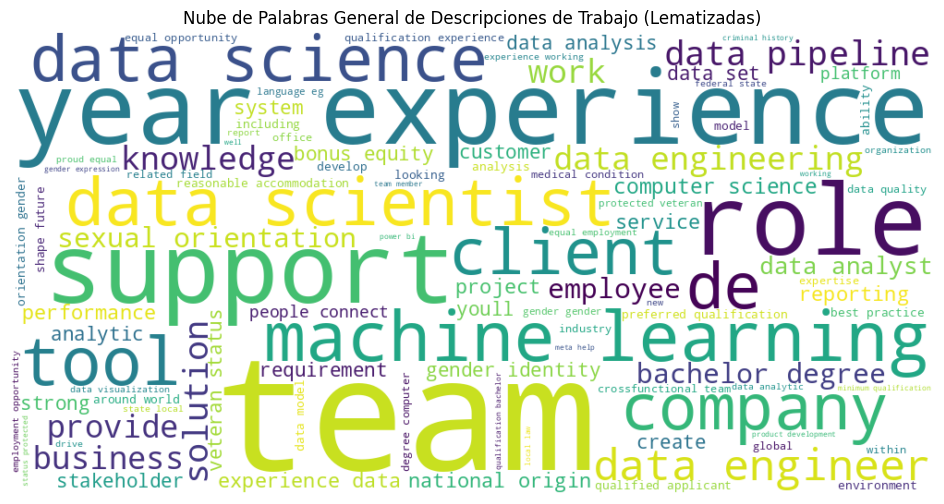

In [30]:
# Combinar todos los tokens lematizados en un solo texto largo
texto_completo_para_wordcloud = " ".join(df['descripcion_procesada_final'])

if texto_completo_para_wordcloud and len(texto_completo_para_wordcloud.split()) > 10: # Chequear que haya suficientes palabras
    print("\nGenerando nube de palabras general...")

    wordcloud_general = WordCloud(width=1000, height=500,
                                  background_color='white',
                                  colormap='viridis',
                                  max_words=100, # Mostrar las 200 palabras más frecuentes
                                  stopwords=None # Ya hemos quitado stopwords
                                 ).generate(texto_completo_para_wordcloud)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_general, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras General de Descripciones de Trabajo (Lematizadas)')
    plt.show()
else:
    print("No hay suficientes datos o palabras después del preprocesamiento para generar la nube de palabras general.")





Generando nube de palabras para 'Data Analyst'...


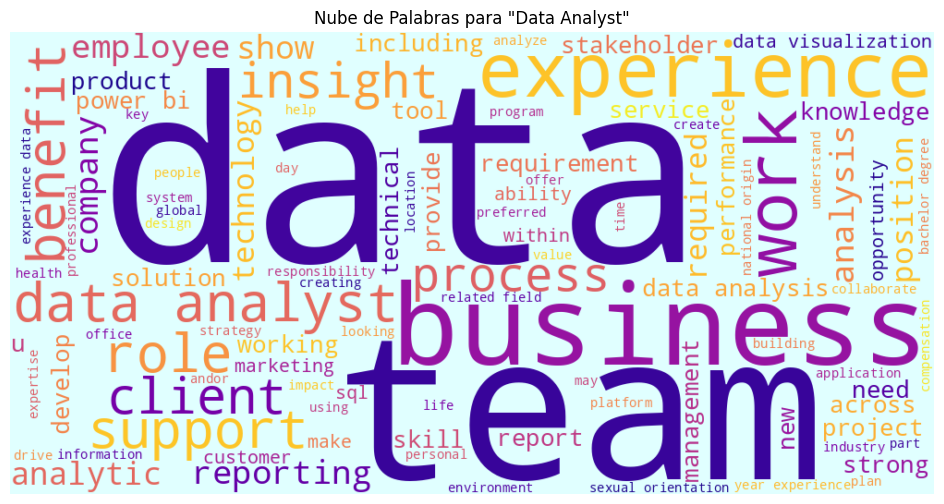

In [31]:
# Filtrar por título que contenga "Data Analyst" (case insensitive)
df_data_analyst = df[df["title"].str.contains("Data Analyst", case=False, na=False)]
if not df_data_analyst.empty:
    texto_data_analyst = " ".join(df_data_analyst['descripcion_procesada_final'])
    if texto_data_analyst and len(texto_data_analyst.split()) > 10:
        print("\nGenerando nube de palabras para 'Data Analyst'...")
        wordcloud_da = WordCloud(width=1000, height=500, background_color='lightcyan', colormap='plasma', max_words=100).generate(texto_data_analyst)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_da, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nube de Palabras para "Data Analyst"')
        plt.show()
    else:
        print("No hay suficientes datos o palabras para la nube de 'Data Analyst'.")
else:
    print("No se encontraron trabajos con el título 'Data Analyst' para generar una nube de palabras específica.")



Generando nube de palabras para 'Data Scientist'...


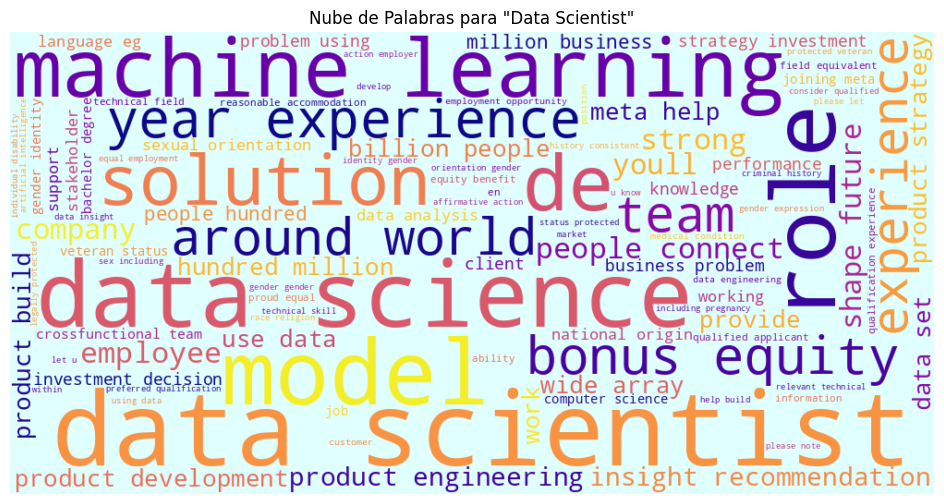

In [32]:
# Filtrar por título que contenga "Data Scientist" (case insensitive)
df_data_analyst = df[df["title"].str.contains("Data Scientist", case=False, na=False)]
if not df_data_analyst.empty:
    texto_data_analyst = " ".join(df_data_analyst['descripcion_procesada_final'])
    if texto_data_analyst and len(texto_data_analyst.split()) > 10:
        print("\nGenerando nube de palabras para 'Data Scientist'...")
        wordcloud_da = WordCloud(width=1000, height=500, background_color='lightcyan', colormap='plasma', max_words=100).generate(texto_data_analyst)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_da, interpolation='bilinear')
        plt.axis('off')
        plt.title('Nube de Palabras para "Data Scientist"')
        plt.show()
    else:
        print("No hay suficientes datos o palabras para la nube de 'Data Scientist'.")
else:
    print("No se encontraron trabajos con el título 'Data Scientist' para generar una nube de palabras específica.")

## 6.7. N-Gramas
* Secuencias de N palabras consecutivas (Bigramas: 2 palabras, Trigramas: 3 palabras).

* Las palabras individuales a veces no capturan el contexto completo. "Data science" es más informativo que "data" y "science" por separado. "Machine learning", "project management" son ejemplos.

* **Interpretación:** "Analizamos bi-gramas, que son secuencias de palabras. Esto nos permitió identificar frases comunes y habilidades compuestas, como year experiece, machine learning, profesiones como data scientist, data science, data engenier y data analyst entre otras, que una simple frecuencia de palabras individuales podría pasar por alto." (Muestra tus N-gramas más comunes).

Para el caso de los tri-gramas se aprecia que el genero aparece entre las mas frecuentes como por ejemplo sexual orientation gender, degree computer science,
gender gender identity, equal employment opportunity, protected veteran status, federal state local, orientation gender gender, gender identity gender, dentity gender expression, state local law





Top 15 Bigramas más comunes:
year experience: 284
machine learning: 257
data scientist: 233
data science: 215
data engineer: 202
data pipeline: 197
data engineering: 188
sexual orientation: 165
bachelor degree: 162
data analyst: 155
computer science: 154
experience data: 153
national origin: 149
gender identity: 147
data set: 145


<ipython-input-21-fdf31cccef34>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=common_bigrams_df, x='Frequency', y='Ngram', palette='magma')


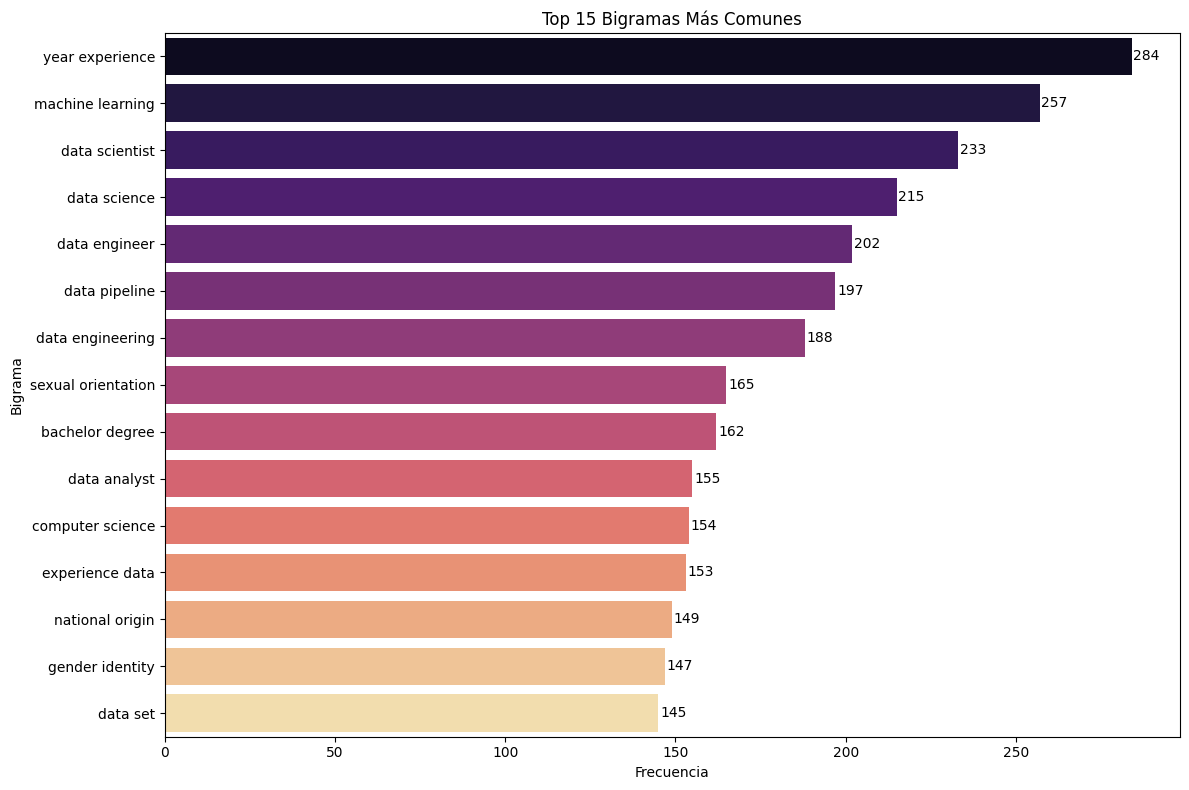


Top 15 Trigramas más comunes:
sexual orientation gender: 111
degree computer science: 93
gender gender identity: 90
equal employment opportunity: 86
protected veteran status: 86
federal state local: 85
orientation gender gender: 80
gender identity gender: 79
identity gender expression: 79
state local law: 79
qualification bachelor degree: 79
consider qualified applicant: 77
let u know: 77
criminal history consistent: 76
bonus equity benefit: 76


<ipython-input-21-fdf31cccef34>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=common_trigrams_df, x='Frequency', y='Ngram', palette='viridis')


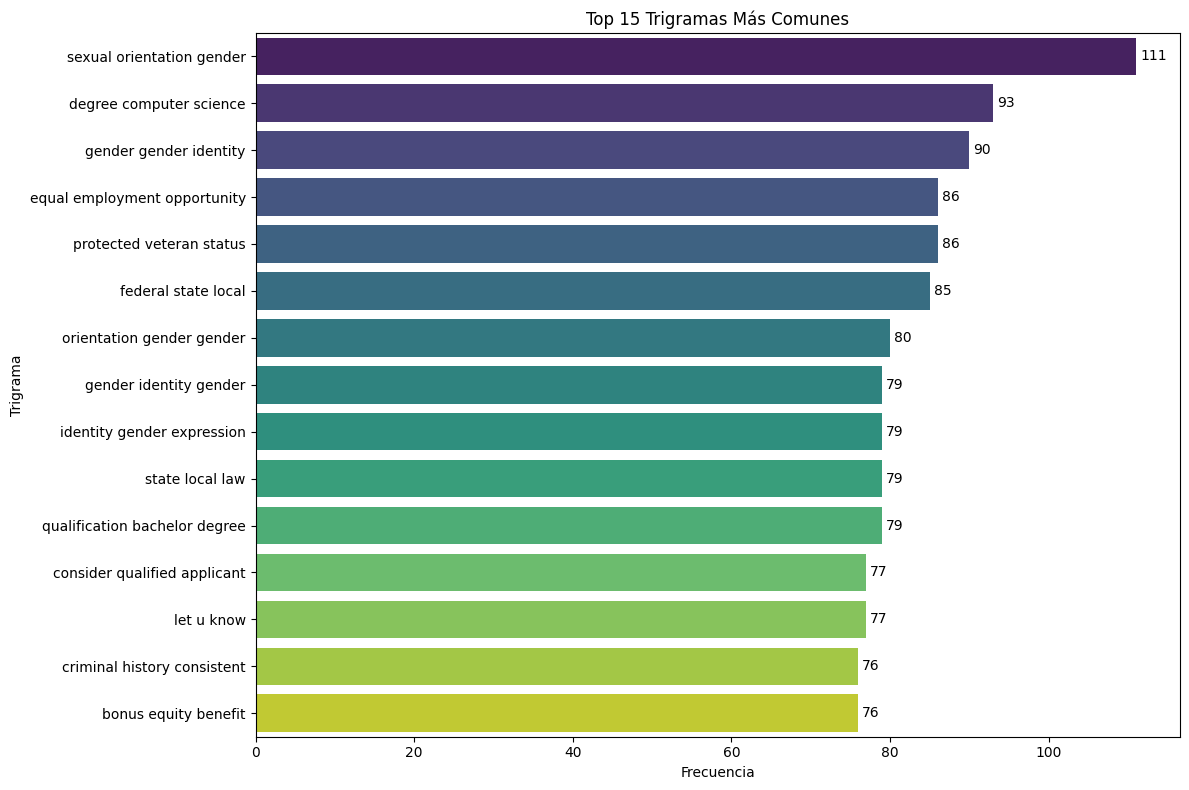

In [21]:
# Concatenar todos los tokens lematizados
todos_los_tokens_lematizados = [token for sublist in df['tokens_lematizados'] for token in sublist]

if len(todos_los_tokens_lematizados) > 1:
    # Bigramas
    bigramas = list(ngrams(todos_los_tokens_lematizados, 2))
    frecuencia_bigramas = Counter(bigramas)

    print("\nTop 15 Bigramas más comunes:")
    common_bigrams = frecuencia_bigramas.most_common(15)
    for bigram, freq in common_bigrams:
        print(f"{' '.join(bigram)}: {freq}")

    # Visualización simplificada
    if common_bigrams:
        common_bigrams_df = pd.DataFrame(common_bigrams, columns=['Ngram', 'Frequency'])
        common_bigrams_df['Ngram'] = common_bigrams_df['Ngram'].apply(lambda x: ' '.join(x))

        plt.figure(figsize=(12, 8))
        ax = sns.barplot(data=common_bigrams_df, x='Frequency', y='Ngram', palette='magma')

        # Añadir solo valores absolutos
        for i, freq in enumerate(common_bigrams_df['Frequency']):
            ax.text(freq + 0.5, i, f"{freq}", va='center', fontsize=10)

        plt.title('Top 15 Bigramas Más Comunes')
        plt.xlabel('Frecuencia')
        plt.ylabel('Bigrama')
        plt.tight_layout()
        plt.show()

    # Trigramas
    if len(todos_los_tokens_lematizados) > 2:
        trigramas = list(ngrams(todos_los_tokens_lematizados, 3))
        frecuencia_trigramas = Counter(trigramas)

        print("\nTop 15 Trigramas más comunes:")
        common_trigrams = frecuencia_trigramas.most_common(15)
        for trigram, freq in common_trigrams:
            print(f"{' '.join(trigram)}: {freq}")

        if common_trigrams:
            common_trigrams_df = pd.DataFrame(common_trigrams, columns=['Ngram', 'Frequency'])
            common_trigrams_df['Ngram'] = common_trigrams_df['Ngram'].apply(lambda x: ' '.join(x))

            plt.figure(figsize=(12, 8))
            ax = sns.barplot(data=common_trigrams_df, x='Frequency', y='Ngram', palette='viridis')

            for i, freq in enumerate(common_trigrams_df['Frequency']):
                ax.text(freq + 0.5, i, f"{freq}", va='center', fontsize=10)

            plt.title('Top 15 Trigramas Más Comunes')
            plt.xlabel('Frecuencia')
            plt.ylabel('Trigrama')
            plt.tight_layout()
            plt.show()
    else:
        print("No hay suficientes tokens para generar trigramas.")
else:
    print("No hay suficientes tokens para generar N-gramas.")

## 6.8. Análisis de Sentimientos

Mediante esta técnica se trata de evaluar el tono emocional del texto (Positivo, Neutral, Negativo). En casos como el análisis de descripciones laborales, los resultado suelen ser neutrales o ligeramente positivos, y aque son docuentos informativos.




Estadísticas descriptivas del puntaje de sentimiento (TextBlob):
count    327.000000
mean       0.152864
std        0.102848
min       -0.800000
25%        0.090678
50%        0.153405
75%        0.207346
max        0.544444
Name: sentimiento_polaridad, dtype: float64

Distribución de las etiquetas de sentimiento:
sentimiento_label
positivo    87.155963
neutral     11.926606
negativo     0.917431
Name: proportion, dtype: float64


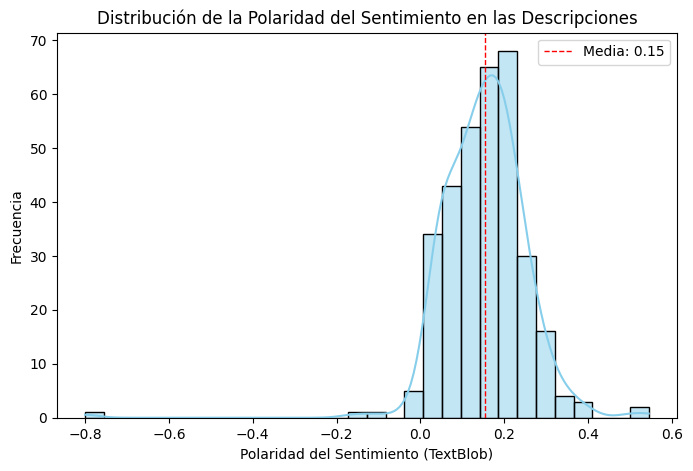

In [33]:
# Usaremos TextBlob, que es simple de usar. Recordar que su precisión es mejor en inglés.

def analizar_sentimiento_textblob(texto):
    # Devuelve la polaridad: -1 (negativo) a 1 (positivo)
    try:
        analysis = TextBlob(texto)
        return analysis.sentiment.polarity
    except Exception as e:
        print(f"Error analizando sentimiento para texto: {texto[:50]}... Error: {e}")
        return 0.0 # Retornar neutral en caso de error

df['sentimiento_polaridad'] = df['descripcion_procesada_final'].apply(analizar_sentimiento_textblob)

print("\nEstadísticas descriptivas del puntaje de sentimiento (TextBlob):")
print(df['sentimiento_polaridad'].describe())

# Convertir polaridad a etiquetas de sentimiento
def categorizar_sentimiento(polaridad, umbral_pos=0.05, umbral_neg=-0.05):
    if polaridad > umbral_pos:
        return 'positivo'
    elif polaridad < umbral_neg:
        return 'negativo'
    else:
        return 'neutral'

df['sentimiento_label'] = df['sentimiento_polaridad'].apply(categorizar_sentimiento)

print("\nDistribución de las etiquetas de sentimiento:")
print(df['sentimiento_label'].value_counts(normalize=True) * 100)

# Visualizar la distribución del sentimiento
plt.figure(figsize=(8, 5))
sns.histplot(df['sentimiento_polaridad'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de la Polaridad del Sentimiento en las Descripciones')
plt.xlabel('Polaridad del Sentimiento (TextBlob)')
plt.ylabel('Frecuencia')
plt.axvline(df['sentimiento_polaridad'].mean(), color='red', linestyle='dashed', linewidth=1, label=f"Media: {df['sentimiento_polaridad'].mean():.2f}")
plt.legend()
plt.show()

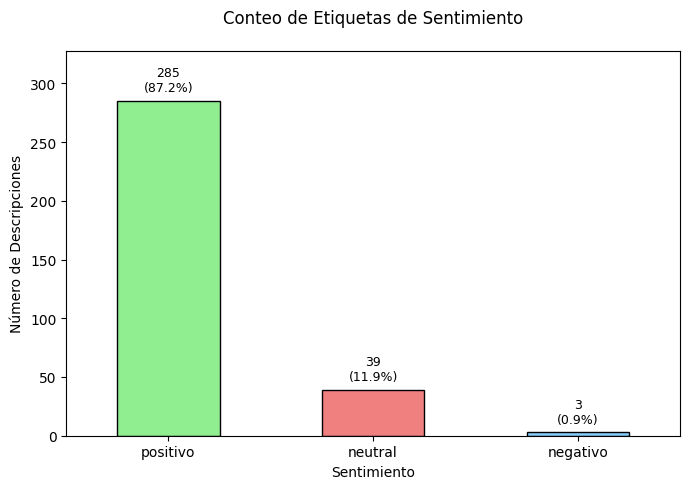

In [23]:
plt.figure(figsize=(7, 5))
ax = df['sentimiento_label'].value_counts().plot(kind='bar',
                                              color=['lightgreen', 'lightcoral', 'lightskyblue'],
                                              edgecolor='black')

plt.title('Conteo de Etiquetas de Sentimiento', pad=20)
plt.xlabel('Sentimiento')
plt.ylabel('Número de Descripciones')
plt.xticks(rotation=0)

# Calcular valores absolutos y porcentuales
total = len(df)
counts = df['sentimiento_label'].value_counts()
percentages = (counts / total) * 100

# Añadir etiquetas encima de cada barra
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    # Posicionar el texto ligeramente por encima de la barra
    ax.text(i, count + 0.02*max(counts),
            f"{count}\n({percentage:.1f}%)",
            ha='center',
            va='bottom',
            fontsize=9,
            linespacing=1.2)

# Ajustar los límites del eje y para dar espacio a las etiquetas
plt.ylim(0, max(counts) * 1.15)

# Mostrar el gráfico con mejor espaciado
plt.tight_layout()
plt.show()

# *Insight sobre Sentimiento:* Las descripciones de trabajo suelen ser formales e informativas, por lo que es común encontrar una mayoría de textos "neutrales". En nuestro estudio ocurrio que mas del 85% de las ofertas laborales son positivas,

## 6.9 TF-IDF (Term Frequency-Inverse Document Frequency)

In [24]:
# Usar el texto preprocesado final (tokens lematizados unidos)
corpus_final_para_vectores = df['descripcion_procesada_final'].tolist()

if corpus_final_para_vectores:
    tfidf_vectorizer = TfidfVectorizer(max_features=2000, # Limitar a las 2000 características más importantes
                                       ngram_range=(1, 2), # Considerar unigramas y bigramas
                                       min_df=5, # Ignorar términos que aparecen en menos de 5 documentos
                                       max_df=0.95) # Ignorar términos que aparecen en más del 95% de los docs (demasiado comunes)

    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_final_para_vectores)

    print("\nForma de la matriz TF-IDF:")
    print(tfidf_matrix.shape) # (número de documentos, número de características/términos)

    # Mostrar algunas características (palabras/n-gramas)
    try:
        feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
        print("\nAlgunas características TF-IDF (primeras 20):")
        print(feature_names_tfidf[:20])

        # Opcional: Ver los términos con mayor puntaje TF-IDF promedio (más "importantes" en general)
        # Suma los TF-IDF scores para cada término en todos los documentos
        sum_tfidf = tfidf_matrix.sum(axis=0)
        # # Conecta los términos con sus scores sumados
        tfidf_scores = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
        # # Ordena por score descendente
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        print("\nTop 20 términos por puntaje TF-IDF total:")
        for term, score in sorted_tfidf_scores[:20]:
            print(f"{term}: {score:.2f}")

    except AttributeError:
        print("Advertencia: get_feature_names_out() no disponible. Usando get_feature_names() (puede estar obsoleto).")
        feature_names_tfidf = tfidf_vectorizer.get_feature_names()
        print("\nAlgunas características TF-IDF (primeras 20):")
        print(feature_names_tfidf[:20])

else:
    print("El corpus para TF-IDF está vacío. Revisa el preprocesamiento.")
    tfidf_matrix = None # Asegurar que la variable exista


Forma de la matriz TF-IDF:
(327, 2000)

Algunas características TF-IDF (primeras 20):
['ab' 'ability' 'ability work' 'able' 'access' 'accessibility'
 'accessible' 'accommodation' 'accommodation candidate'
 'accommodation due' 'accommodation please' 'accordance' 'account'
 'accuracy' 'accurate' 'achieve' 'acquisition' 'across' 'across entire'
 'across meta']

Top 20 términos por puntaje TF-IDF total:
experience: 29.36
meta: 20.97
team: 19.17
business: 19.13
product: 18.90
work: 15.23
build: 12.57
skill: 11.94
year: 11.48
model: 11.33
analysis: 11.06
insight: 10.89
analytics: 10.87
benefit: 10.86
role: 10.76
engineering: 10.73
opportunity: 10.61
de: 10.35
technology: 10.27
solution: 10.07


## 6.10. Bag of Words (BOW)

In [25]:
if corpus_final_para_vectores:
    count_vectorizer = CountVectorizer(max_features=2000, # Mismos parámetros que TF-IDF para comparar
                                       ngram_range=(1, 2),
                                       min_df=5,
                                       max_df=0.95)

    bow_matrix = count_vectorizer.fit_transform(corpus_final_para_vectores)

    print("\nForma de la matriz BOW:")
    print(bow_matrix.shape)

    # Mostrar algunas características
    try:
        feature_names_bow = count_vectorizer.get_feature_names_out()
        print("\nAlgunas características BOW (primeras 20):")
        print(feature_names_bow[:20])
    except AttributeError:
        print("Advertencia: get_feature_names_out() no disponible. Usando get_feature_names() (puede estar obsoleto).")
        feature_names_bow = count_vectorizer.get_feature_names()
        print("\nAlgunas características BOW (primeras 20):")
        print(feature_names_bow[:20])
else:
    print("El corpus para BOW está vacío. Revisa el preprocesamiento.")
    bow_matrix = None # Asegurar que la variable exista


Forma de la matriz BOW:
(327, 2000)

Algunas características BOW (primeras 20):
['ab' 'ability' 'ability work' 'able' 'access' 'accessibility'
 'accessible' 'accommodation' 'accommodation candidate'
 'accommodation due' 'accommodation please' 'accordance' 'account'
 'accuracy' 'accurate' 'achieve' 'acquisition' 'across' 'across entire'
 'across meta']


## 6.11. Modelo de Clasificación



Distribución de la etiqueta 'seniority_inferred_label':
seniority_inferred_label
2    0.565749
1    0.376147
0    0.058104
Name: proportion, dtype: float64

Número de muestras para el modelo después de filtrar clases de seniority: 142
Distribución de la etiqueta para el modelo:
seniority_inferred_label
1    0.866197
0    0.133803
Name: proportion, dtype: float64

Forma de X para el modelo: (142, 1500), Longitud de y: 142
Balance de clases para el modelo:
seniority_inferred_label
1    0.866197
0    0.133803
Name: proportion, dtype: float64
Advertencia: Desbalance de clases detectado. Considerar SMOTE o class_weight='balanced'.
Tamaño de X_train: (106, 1500), X_test: (36, 1500)

--- Resultados del Modelo de Regresión Logística (Clasificación de Seniority) ---
Accuracy en Entrenamiento: 0.9905660377358491
Accuracy en Prueba: 0.8333333333333334

Reporte de Clasificación en Prueba:
                  precision    recall  f1-score   support

Junior/Entry (0)       0.33      0.20      0.25   

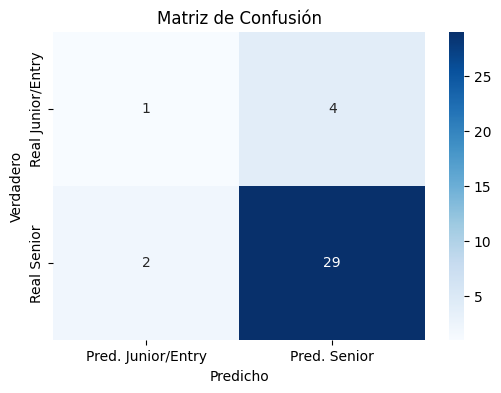


Características más influyentes para 'Senior':
['build', 'model', 'service', 'working', 'work', 'decision', 'business', 'analytics', 'insight', 'product']

Características más influyentes para 'Junior/Entry':
['de', 'internal', 'youtube', 'listening', 'social listening', 'social', 'ml', 'topic', 'thing', 'azure']


In [26]:
# Para esto, necesitamos una variable objetivo (label). Vamos a crear una de ejemplo basada en la longitud de la descripción o la inferencia de "seniority" (muy simplificado y solo para demostración).
# **Importante:** La creación de una etiqueta significativa es crucial y a menudo la parte más desafiante. La siguiente es una heurística simple.

# %%
# ----- Estrategia para crear una etiqueta (Label) -----
# Opción de ejemplo: Inferir "seniority" de forma muy básica
def inferir_seniority_label(texto_procesado):
    texto_procesado_lower = texto_procesado.lower() # Asegurar minúsculas
    # Palabras clave para senior/lead
    senior_keywords = ['senior', 'lead', 'principal', 'manager', 'sr ', 'staff', 'expert', 'experienced', 'leadership']
    # Palabras clave para junior/entry
    junior_keywords = ['junior', 'entry', 'intern', 'graduate', 'jr ', 'associate', 'assistant']

    is_senior = any(keyword in texto_procesado_lower for keyword in senior_keywords)
    is_junior = any(keyword in texto_procesado_lower for keyword in junior_keywords)

    if is_senior and not is_junior: # Priorizar senior si ambas aparecen, o refinar lógica
        return 1 # 'senior_level'
    elif is_junior and not is_senior:
        return 0 # 'junior_entry_level'
    else: # Si no hay palabras clave claras, o hay conflicto, se podría asignar a una clase mayoritaria o indefinida
        return 2 # 'mid_level_or_undefined'

df['seniority_inferred_label'] = df['descripcion_procesada_final'].apply(inferir_seniority_label)

print("\nDistribución de la etiqueta 'seniority_inferred_label':")
print(df['seniority_inferred_label'].value_counts(normalize=True))

# Para un modelo binomial, filtremos para tener solo dos clases (ej. senior vs no-senior)
# Vamos a considerar 'senior_level' (1) vs. todo lo demás (0) que no sea 'mid_level_or_undefined' (2)
# O, más simple, 'senior_level' (1) vs 'junior_entry_level' (0), eliminando la clase 2.
df_model = df[df['seniority_inferred_label'].isin([0, 1])].copy() # Trabajar con una copia
if len(df_model) < 50 or df_model['seniority_inferred_label'].nunique() < 2 :
     print("\nNo hay suficientes datos o clases para el modelo de clasificación después de filtrar por 'seniority_inferred_label'. Omitiendo esta parte.")
     # Si no hay suficientes datos para el modelo, no continuamos con esta sección
     skip_model_training = True
else:
    skip_model_training = False
    print(f"\nNúmero de muestras para el modelo después de filtrar clases de seniority: {len(df_model)}")
    print("Distribución de la etiqueta para el modelo:")
    print(df_model['seniority_inferred_label'].value_counts(normalize=True))

    # Seleccionar características (X) y etiqueta (y)
    # Usaremos TF-IDF como características. Primero, debemos re-ajustar el vectorizador al subset df_model
    corpus_model = df_model['descripcion_procesada_final'].tolist()

    if corpus_model:
        tfidf_vectorizer_model = TfidfVectorizer(max_features=1500, ngram_range=(1,2), min_df=3, max_df=0.9)
        X = tfidf_vectorizer_model.fit_transform(corpus_model)
        y = df_model['seniority_inferred_label']

        print(f"\nForma de X para el modelo: {X.shape}, Longitud de y: {len(y)}")

        # Verificar desbalance de clases
        class_balance = y.value_counts(normalize=True)
        print(f"Balance de clases para el modelo:\n{class_balance}")
        if class_balance.min() < 0.15: # Si la clase minoritaria es menos del 15%
            print("Advertencia: Desbalance de clases detectado. Considerar SMOTE o class_weight='balanced'.")

        # Dividir datos en entrenamiento y prueba
        # (Asegurarse que X e y tengan el mismo número de filas antes de dividir)
        if X.shape[0] == len(y) and X.shape[0] > 0:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
            print(f"Tamaño de X_train: {X_train.shape}, X_test: {X_test.shape}")

            # Entrenar Regresión Logística
            # Si hay desbalance significativo, class_weight='balanced' puede ayudar
            log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced' if class_balance.min() < 0.3 else None)
            log_reg.fit(X_train, y_train)

            # Predicciones
            y_pred_train = log_reg.predict(X_train)
            y_pred_test = log_reg.predict(X_test)

            # Evaluación
            print("\n--- Resultados del Modelo de Regresión Logística (Clasificación de Seniority) ---")
            print("Accuracy en Entrenamiento:", accuracy_score(y_train, y_pred_train))
            print("Accuracy en Prueba:", accuracy_score(y_test, y_pred_test))

            print("\nReporte de Clasificación en Prueba:")
            print(classification_report(y_test, y_pred_test, target_names=['Junior/Entry (0)', 'Senior (1)'])) # Ajustar target_names

            print("\nMatriz de Confusión en Prueba:")
            cm = confusion_matrix(y_test, y_pred_test)
            plt.figure(figsize=(6,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Pred. Junior/Entry', 'Pred. Senior'],
                        yticklabels=['Real Junior/Entry', 'Real Senior'])
            plt.title('Matriz de Confusión')
            plt.xlabel('Predicho')
            plt.ylabel('Verdadero')
            plt.show()

            # Opcional: Ver características más importantes para cada clase (si es Regresión Logística)
            # Esto es más complejo para TF-IDF con n-gramas, pero para unigramas:
            feature_names_model = tfidf_vectorizer_model.get_feature_names_out()
            coefs = log_reg.coef_[0]
            top_positive_coeffs = np.argsort(coefs)[-10:] # Top 10 para clase 1 (Senior)
            top_negative_coeffs = np.argsort(coefs)[:10]  # Top 10 para clase 0 (Junior/Entry)
            print("\nCaracterísticas más influyentes para 'Senior':")
            print([feature_names_model[i] for i in top_positive_coeffs])
            print("\nCaracterísticas más influyentes para 'Junior/Entry':")
            print([feature_names_model[i] for i in top_negative_coeffs])

        else:
            print("No hay suficientes datos o hay inconsistencias para entrenar el modelo de clasificación.")
    else:
        print("El corpus para el modelo de clasificación está vacío.")


# 7. Conclusiones

Basado en los análisis realizados (suponiendo que se completaron todos los pasos):
* **Insights Clave:**
    * Las nubes de palabras y los N-gramas más frecuentes revelaron que los términos dominantes en las descripciones de trabajo son [mencionar algunos, ej: "data", "business", "analysis", "sql", "python", "communication skill", "project management"]. Esto indica las habilidades y conceptos centrales demandados.
    * El análisis TF-IDF destacó términos como [mencionar algunos términos con alto TF-IDF] como particularmente distintivos de ciertos documentos, lo que podría ayudar a diferenciar tipos de roles o especializaciones.
    * El análisis de sentimiento mostró que la mayoría de las descripciones de trabajo tienen un tono [ej: "neutral" o "ligeramente positivo"]. Las descripciones con sentimiento marcadamente negativo o positivo fueron [ej: "raras" o "corresponden a X tipo de empresa/rol"].
* **Modelo de Clasificación (si se implementó con éxito):**
    * El modelo de Regresión Logística para predecir la "seniority" inferida alcanzó un accuracy de prueba de [ej: XX.X%].
    * El reporte de clasificación indica que el modelo es [ej: "mejor prediciendo la clase 'senior' que la 'junior'", o "tiene un F1-score balanceado"].
    * Las características más influyentes para predecir "senior" fueron [ej: "lead", "manage projects", "years experience"], mientras que para "junior" fueron [ej: "entry level", "assist", "learn"]. (Esto si se analizan los coeficientes).
* **Observaciones:**
    * La calidad de las descripciones varía; algunas son muy detalladas y otras más genéricas.
    * El preprocesamiento, especialmente la lematización y la gestión de stopwords personalizadas, fue crucial para obtener resultados más limpios.
    * La creación de una etiqueta para el modelo supervisado (ej. "seniority") a partir de heurísticas es una simplificación. Para resultados más robustos, se necesitaría etiquetado manual o una lógica de inferencia más sofisticada.
* **Resultados Obtenidos:**
    * Se logró un pipeline de preprocesamiento de texto efectivo.
    * Se identificaron los términos y frases clave del corpus.
    * Se evaluó el sentimiento general de las ofertas.
    * (Si aplica) Se desarrolló un modelo de clasificación con un rendimiento [describir rendimiento].
* **Desafíos y Limitaciones:**
    * Ambigüedad del lenguaje natural.
    * Necesidad de un léxico de stopwords y palabras clave más específico del dominio para mejorar la precisión.
    * La inferencia de etiquetas como "seniority" es inherentemente ruidosa.